# Problem Set 1

The function polyfit computes $\boldsymbol{\theta}$ in
$$ \mathsf{M}_x\boldsymbol{\theta} =  \mathsf{M}_y$$
where
$$(\mathsf{M}_x)_{ij} = \mathbf{X}^T_i \mathsf{C}^{-1} \mathbf{X}_j,$$
$$(\mathsf{M}_y)_{i} = \mathbf{X}^T_i \mathsf{C}^{-1} \mathbf{Y},$$
and
$$(\mathbf{X}_i)_j = (x_j)^i.$$
The vector $\mathbf{X}$ (or $\mathbf{X}_1$) contains the x values of the data, $\mathbf{Y}$ the y values, and $\mathsf{C}$ the squared uncertainties of y values.

In [1]:
#Let there be np.light
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
#Extracting data
with open("data.csv","r") as csvfile:
    data_object = csv.reader(csvfile)
    data = np.array(list(data_object)).astype("float64")
    x_vals = data[:,0]
    y_vals = data[:,1]
    sigma_vals = data[:,2]

In [3]:
#Constructing fitter
def polyfit(y_array,x_array,sigma_array,order):
    N = int(order + 1) #number of variational parameters
    
    #Creating the NxN M_x coefficient matrix
    M_x = np.array([[np.sum(x_array**i*sigma_array**(-2)*x_array**j) for j in range(N)] for i in range(N)])
    
    #Creating the Nx1 M_y ordinate vector
    M_y = np.array([np.sum(x_array**i*sigma_array**(-2)*y_array) for i in range(N)])
    
    #Solving for fit parameters. 
    #Output is in ascending coefficient order (e.g., for linear fit: "(intercept, slope)").
    return (np.linalg.solve(M_x,M_y))

# Plots

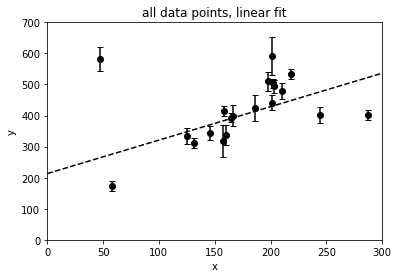

Fit parameter values (ascending order): [213.27349198   1.07674752]


In [4]:
#Plot: all data points, linear fit

fit1 = polyfit(y_vals,x_vals,sigma_vals,1)

plt.errorbar(x_vals,y_vals,yerr=sigma_vals,fmt="o",color="black",solid_capstyle="projecting",capsize=3)
plt.xlim(0,300)
plt.ylim(0,700)
plt.xlabel("x")
plt.ylabel("y")
plt.plot(np.arange(0,300),np.arange(300)*fit1[1]+fit1[0],linestyle="--",color="black")
plt.title('all data points, linear fit')

plt.show()

print(f"Fit parameter values (ascending order): {fit1}")

**Some data points are "outliers".**

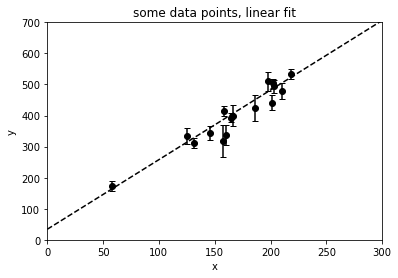

Fit parameter values (ascending order): [34.04772776  2.23992083]


In [5]:
#Plots: some data points removed, linear fit

x_vals_cut = data[4:,0]
y_vals_cut = data[4:,1]
sigma_vals_cut = data[4:,2]
fit2 = polyfit(y_vals_cut,x_vals_cut,sigma_vals_cut,1)

plt.errorbar(x_vals_cut,y_vals_cut,yerr=sigma_vals_cut,fmt="o",color="black",solid_capstyle="projecting",capsize=3)
plt.xlim(0,300)
plt.ylim(0,700)
plt.xlabel("x")
plt.ylabel("y")
plt.plot(np.arange(0,300),np.arange(300)*fit2[1]+fit2[0],linestyle="--",color="black")
plt.title('some data points, linear fit')

plt.show()

print(f"Fit parameter values (ascending order): {fit2}")

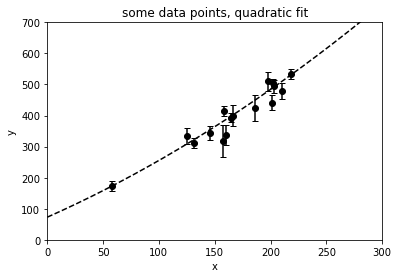

Fit parameter values (ascending order): [7.28946265e+01 1.59605045e+00 2.29888841e-03]


In [6]:
#Plots: some data points removed, quadratic fit

fit3 = polyfit(y_vals_cut,x_vals_cut,sigma_vals_cut,2)

plt.errorbar(x_vals_cut,y_vals_cut,yerr=sigma_vals_cut,fmt="o",color="black",solid_capstyle="projecting",capsize=3)
plt.xlim(0,300)
plt.ylim(0,700)
plt.xlabel("x")
plt.ylabel("y")
plt.plot(np.arange(0,300),np.arange(300)**2*fit3[2]+np.arange(300)*fit3[1]+fit3[0],linestyle="--",color="black")
plt.title('some data points, quadratic fit')

plt.show()

print(f"Fit parameter values (ascending order): {fit3}")

# Uncertainty of parameters

All data points included. Linear fit only.

In [10]:
#Standard uncertainties
N = 2
M_x = np.array([[np.sum(x_vals**i*sigma_vals**(-2)*x_vals**j) for j in range(N)] for i in range(N)])

print(f'Standard uncertainties "(mean,variance)", values in ascending parameter coeff order:\n\n{(fit1,np.array([M_x[1,1],M_x[0,0]])/np.linalg.det(M_x))}')

Standard uncertainties "(mean,variance)", values in ascending parameter coeff order:

(array([213.27349198,   1.07674752]), array([2.07188189e+02, 5.99181008e-03]))


In [11]:
#Jackknife resampling
def jackknife(y_array,x_array,sigma,order):
    cmoment_1 = np.zeros(order+1)
    cmoment_2 = np.zeros(order+1)
    
    for i in range(len(y_array)):
        y_cut = np.delete(y_array,i)
        x_cut = np.delete(x_array,i)
        sigma_cut = np.delete(sigma,i)
        par_sample = polyfit(y_cut,x_cut,sigma_cut,order)
        cmoment_1 += par_sample
        cmoment_2 += par_sample**2
    
    mean = cmoment_1/len(y_array)
    variance = (len(y_array)-1)*(cmoment_2/len(y_array) - mean**2)
    
    return (mean,variance)

print(f'Jackknife resampling results in "(mean,variance)", values in ascending parameter coeff order:\n\n{jackknife(y_vals,x_vals,sigma_vals,1)}')

Jackknife resampling results in "(mean,variance)", values in ascending parameter coeff order:

(array([214.27620119,   1.07525455]), array([2.4020988e+04, 7.6394608e-01]))


In [16]:
#Bootstrap resampling

def bootstrap(data_in,order):
    cmoment_1 = np.zeros(order+1)
    cmoment_2 = np.zeros(order+1)
    
    for i in range(len(data_in)):
        sample = np.array([data_in[int(np.random.random_sample()*len(data_in))] for i in range(len(data_in))])
        par_sample = polyfit(sample[:,1],sample[:,0],sample[:,2],order)
        cmoment_1 += par_sample
        cmoment_2 += par_sample**2
        
    mean = cmoment_1/len(data_in)
    variance = cmoment_2/len(data_in) - mean**2
    
    return (mean,variance)

print(f'Bootstrap resampling results in "(mean,variance)", values in ascending parameter coeff order:\n\n{bootstrap(data,1)}')

Bootstrap resampling results in "(mean,variance)", values in ascending parameter coeff order:

(array([205.24407457,   1.19044152]), array([1.22877242e+04, 3.66526307e-01]))


**The uncertainty values from both resampling schemes are far off from the standard uncertainties of the parameter. The difference is 2 orders of magnitude for the variance. However, the bootstrap resampling is often the one that gets slightly closer to the standard uncertainty.**